In [377]:

# importing basic libraries
import pandas as pd
from pandas import DataFrame
import numpy as np

import requests
import random
import xlrd
import csv
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# visualization/plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  
import matplotlib.pyplot as plt
# setting to default parameters
plt.rcParams.update(plt.rcParamsDefault)

# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("white")
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# Let's import the libraries required for the image classification
import os
import glob
RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import tensorflow as tf
tf.random.set_seed(RAND_SEED)
import random
random.seed(RAND_SEED)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# matplotlib settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["axes.grid"] = False


In [378]:
# setting seed for model reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [379]:
def pre_process(df, column):
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.info()
    print(df.columns)
    # descriptive statistics
    df.describe().T
    df.head(15)
    df.nunique()    
    df.dtypes
    df.shape
    # filtering
    df.dropna(inplace=True)
    # drop rows where oil rate is 0
    df = df[(df[column].notnull()) & (df[column] > 0)]
    return df


In [380]:
# reading train and test data

train_prod = pd.read_csv('data/train_prod.csv')
test_prod = pd.read_csv("data/test_prod.csv")

# Basic Processing and data exploration
train_prod = pre_process(train_prod, 'Oil')
test_prod = pre_process(test_prod, 'Oil')

# convert time to datetime and set as dataframe index
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])

#bakken_data.set_index("ReportDate", inplace=True)
train_prod["First_Prod_Date"] = train_prod.groupby("API_WELLNO")["ReportDate"].transform('min')
train_prod["Days_Online"] = (train_prod["ReportDate"] - train_prod["First_Prod_Date"]).dt.days 

# find the top 10 wells with highest production (sum)
grouped_data = train_prod.groupby(['API_WELLNO']).sum()
grouped_data = grouped_data.sort_values(by=['Oil'])
grouped_data = grouped_data.nlargest(10, 'Oil').reset_index()

example_wells = grouped_data['API_WELLNO'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684415 entries, 0 to 684414
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ReportDate  684415 non-null  object 
 1   API_WELLNO  684415 non-null  float64
 2   FileNo      684415 non-null  float64
 3   Company     684415 non-null  object 
 4   WellName    684415 non-null  object 
 5   Quarter     684415 non-null  object 
 6   Section     684415 non-null  float64
 7   Township    684415 non-null  float64
 8   Range       684415 non-null  float64
 9   County      684415 non-null  object 
 10  FieldName   684415 non-null  object 
 11  Pool        684415 non-null  object 
 12  Oil         678599 non-null  float64
 13  Wtr         678599 non-null  float64
 14  Days        678599 non-null  float64
 15  Runs        684415 non-null  float64
 16  Gas         678599 non-null  float64
 17  GasSold     684415 non-null  float64
 18  Flared      678599 non-null  float64
 19  La

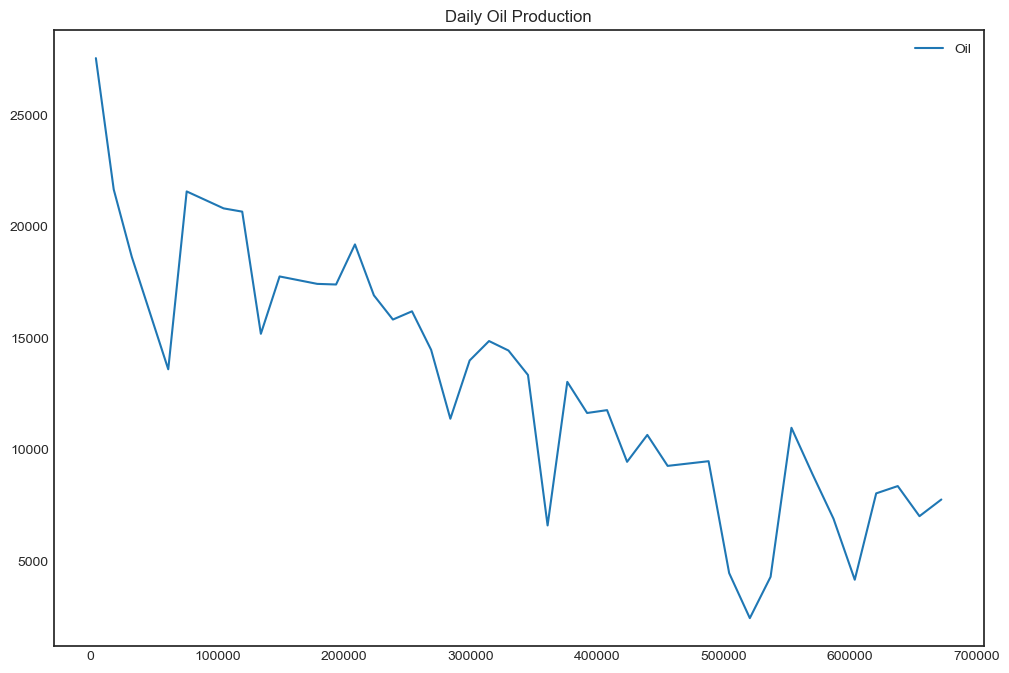

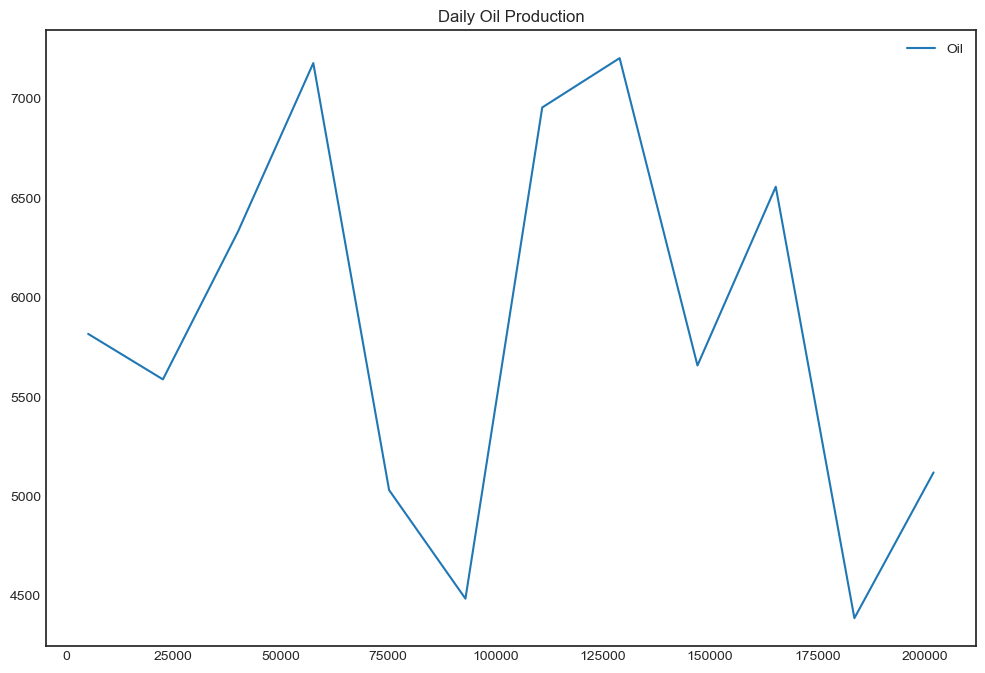

In [381]:
df_temp = train_prod[(train_prod['API_WELLNO'] == 33055001360000)]
df_test = test_prod[(test_prod['API_WELLNO'] == 33055001360000)]
df_temp.plot(y='Oil', title='Daily Oil Production')
df_test.plot(y='Oil', title='Daily Oil Production')
plt.show()

In [382]:
frames = [df_temp, df_test]
dataframe = pd.concat(frames)
dataframe.set_index("ReportDate", inplace=True)
dataset=pd.DataFrame(dataframe['Oil'])
dataset=dataset.values
#dataset.reshape(-1, 1)
#dataset = dataset.astype('float32')
#dataset = pd.DataFrame(dataset)
#dataset.info()

In [383]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [384]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

36 16


In [385]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [386]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [387]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [388]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32,activation='relu', input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY,validation_data=(testX, testY), epochs=200, batch_size=1, verbose=2)

Epoch 1/200
31/31 - 1s - loss: 0.1188 - val_loss: 0.0433
Epoch 2/200
31/31 - 0s - loss: 0.0260 - val_loss: 0.0475
Epoch 3/200
31/31 - 0s - loss: 0.0240 - val_loss: 0.0405
Epoch 4/200
31/31 - 0s - loss: 0.0210 - val_loss: 0.0255
Epoch 5/200
31/31 - 0s - loss: 0.0185 - val_loss: 0.0237
Epoch 6/200
31/31 - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 7/200
31/31 - 0s - loss: 0.0148 - val_loss: 0.0119
Epoch 8/200
31/31 - 0s - loss: 0.0133 - val_loss: 0.0118
Epoch 9/200
31/31 - 0s - loss: 0.0122 - val_loss: 0.0065
Epoch 10/200
31/31 - 0s - loss: 0.0114 - val_loss: 0.0060
Epoch 11/200
31/31 - 0s - loss: 0.0105 - val_loss: 0.0023
Epoch 12/200
31/31 - 0s - loss: 0.0110 - val_loss: 0.0028
Epoch 13/200
31/31 - 0s - loss: 0.0100 - val_loss: 0.0027
Epoch 14/200
31/31 - 0s - loss: 0.0099 - val_loss: 0.0027
Epoch 15/200
31/31 - 0s - loss: 0.0103 - val_loss: 0.0032
Epoch 16/200
31/31 - 0s - loss: 0.0099 - val_loss: 0.0019
Epoch 17/200
31/31 - 0s - loss: 0.0098 - val_loss: 0.0019
Epoch 18/200
31/31 - 0s

Epoch 142/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0031
Epoch 143/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0031
Epoch 144/200
31/31 - 0s - loss: 0.0058 - val_loss: 0.0035
Epoch 145/200
31/31 - 0s - loss: 0.0059 - val_loss: 0.0027
Epoch 146/200
31/31 - 0s - loss: 0.0058 - val_loss: 0.0035
Epoch 147/200
31/31 - 0s - loss: 0.0063 - val_loss: 0.0037
Epoch 148/200
31/31 - 0s - loss: 0.0052 - val_loss: 0.0031
Epoch 149/200
31/31 - 0s - loss: 0.0059 - val_loss: 0.0034
Epoch 150/200
31/31 - 0s - loss: 0.0064 - val_loss: 0.0043
Epoch 151/200
31/31 - 0s - loss: 0.0062 - val_loss: 0.0045
Epoch 152/200
31/31 - 0s - loss: 0.0066 - val_loss: 0.0053
Epoch 153/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0034
Epoch 154/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0035
Epoch 155/200
31/31 - 0s - loss: 0.0065 - val_loss: 0.0039
Epoch 156/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0035
Epoch 157/200
31/31 - 0s - loss: 0.0061 - val_loss: 0.0043
Epoch 158/200
31/31 - 0s - loss: 0.0058 - val_loss: 0.00

In [389]:
import math
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Train Score: 1743.42 RMSE
Test Score: 1663.18 RMSE


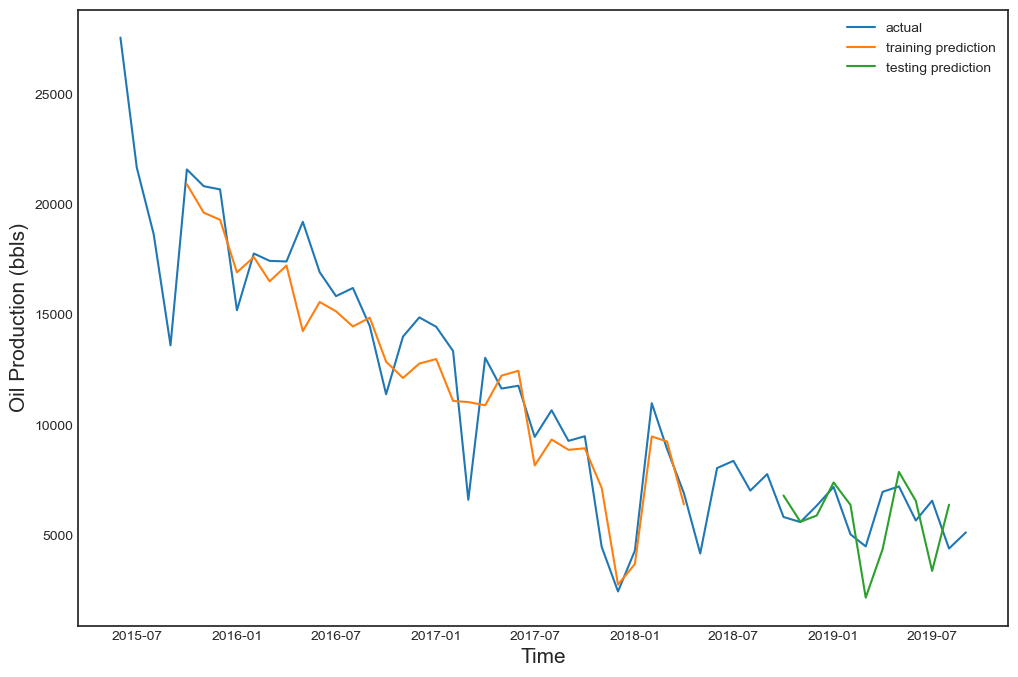

In [390]:
time = pd.date_range(start='6/1/2015', periods= 52, freq='MS')
plt.plot(time,scaler.inverse_transform(dataset),label='actual')
plt.plot(time,trainPredictPlot,label='training prediction')
plt.plot(time,testPredictPlot,label='testing prediction')
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontsize = 15)
plt.legend(loc='best')
plt.legend()
plt.show()

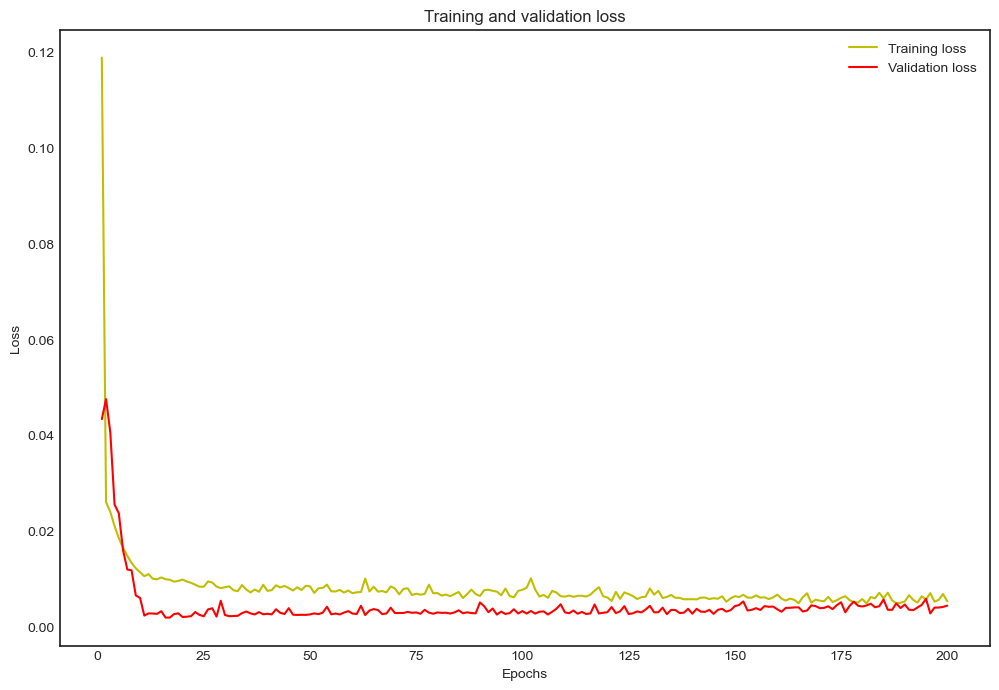

In [391]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


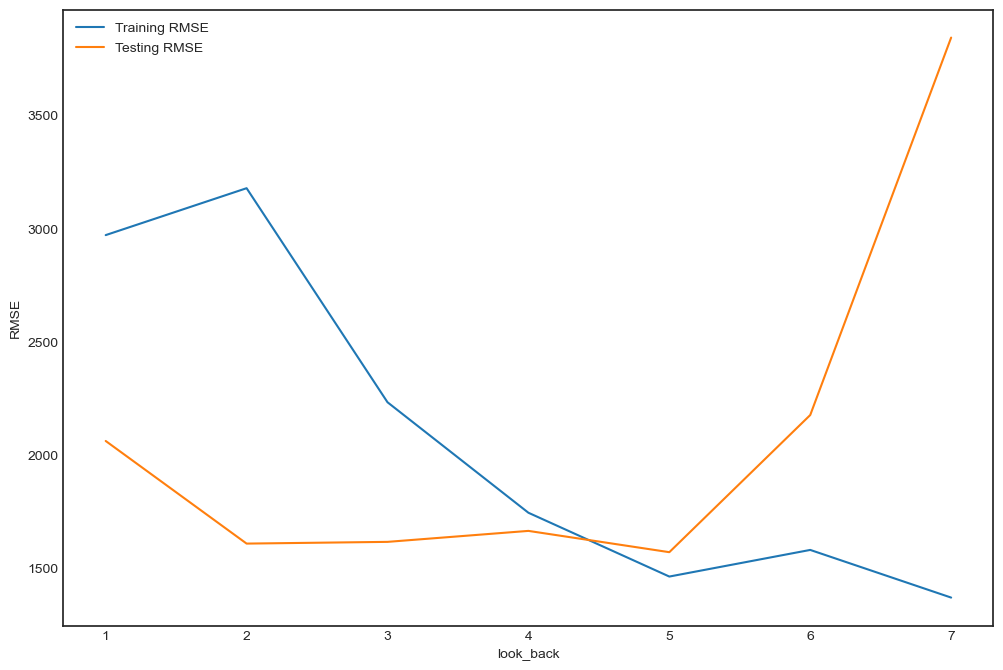

In [394]:
look_back=[1,2,3,4,5,6,7]
Train_RMSE = [2971.26,3178.72,2232.05,1743.42,1461.24,1579,1368.24]
Test_RMSE=[2060.87,1607.01,1614.63,1663.18,1569.02,2175.56,3844.81]
plt.plot(look_back,Train_RMSE, label="Training RMSE")
plt.plot(look_back,Test_RMSE,label="Testing RMSE")
plt.xlabel('look_back')
plt.ylabel('RMSE')
plt.legend()
plt.show()